<a href="https://colab.research.google.com/github/aryan2107-cloud/100-Day-ML-Challenge-/blob/main/Day05_Outlier_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import os

# Create the folder path
folder_path = '/content/drive/MyDrive/100-days-of-ml/phase-1-data-foundations/Day05-Outlier_detection'
os.makedirs(folder_path, exist_ok=True)

print(f'✓ Created: {folder_path}')

✓ Created: /content/drive/MyDrive/100-days-of-ml/phase-1-data-foundations/Day05-Outlier_detection


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from scipy import stats

plt.style.use('seaborn-v0_8-whitegrid')

In [7]:
df_full = pd.read_parquet("/content/yellow_tripdata_2024-01[1].parquet")

In [8]:
np.random.seed(42)
df = df_full.sample(n=100000).reset_index(drop=True)

print(f"Working with {len(df):,} sampled trips")
print(f"\nColumns:")
for col in df.columns:
  print(f" - {col}")

Working with 100,000 sampled trips

Columns:
 - VendorID
 - tpep_pickup_datetime
 - tpep_dropoff_datetime
 - passenger_count
 - trip_distance
 - RatecodeID
 - store_and_fwd_flag
 - PULocationID
 - DOLocationID
 - payment_type
 - fare_amount
 - extra
 - mta_tax
 - tip_amount
 - tolls_amount
 - improvement_surcharge
 - total_amount
 - congestion_surcharge
 - Airport_fee


In [9]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
0,2,2024-01-20 13:31:30,2024-01-20 14:03:25,2.0,17.14,2.0,N,132,233,1,70.0,0.0,0.5,8.27,6.94,1.0,90.96,2.5,1.75
1,2,2024-01-18 21:52:46,2024-01-18 22:03:21,1.0,2.49,1.0,N,163,75,1,13.5,1.0,0.5,4.00,0.00,1.0,22.50,2.5,0.00
2,2,2024-01-01 03:43:58,2024-01-01 03:50:47,2.0,1.84,1.0,N,127,20,2,10.0,1.0,0.5,0.00,0.00,1.0,12.50,0.0,0.00
3,1,2024-01-19 22:20:12,2024-01-19 22:50:12,1.0,3.60,1.0,N,186,263,1,23.3,3.5,0.5,5.65,0.00,1.0,33.95,2.5,0.00
4,2,2024-01-06 22:41:50,2024-01-06 22:43:24,1.0,0.04,1.0,N,238,238,2,3.7,1.0,0.5,0.00,0.00,1.0,6.20,0.0,0.00


In [10]:
#Data types and info
print("Data Types: ")
print(df.dtypes)

print(f"\nMissing Values: ")
missing = df.isnull().sum()
print(missing[missing > 0])

Data Types: 
VendorID                          int32
tpep_pickup_datetime     datetime64[us]
tpep_dropoff_datetime    datetime64[us]
passenger_count                 float64
trip_distance                   float64
RatecodeID                      float64
store_and_fwd_flag               object
PULocationID                      int32
DOLocationID                      int32
payment_type                      int64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
improvement_surcharge           float64
total_amount                    float64
congestion_surcharge            float64
Airport_fee                     float64
dtype: object

Missing Values: 
passenger_count         4727
RatecodeID              4727
store_and_fwd_flag      4727
congestion_surcharge    4727
Airport_fee             4727
dtype: int64


In [11]:
#key_columns for outlier detection
key_cols = ['trip_distance', "fare_amount", "tip_amount", 'total_amount', 'passenger_count']

print("Summary Statistics:")
df[key_cols].describe()

Summary Statistics:


,trip_distance,fare_amount,tip_amount,total_amount,passenger_count
count,100000.000000,100000.000000,100000.000000,100000.000000,95273.000000
mean,3.207086,18.088864,3.319624,26.675305,1.337252
std,4.326738,18.008461,4.117138,22.666931,0.843609
min,0.000000,-170.000000,-1.000000,-188.710000,0.000000
25%,1.000000,8.600000,1.000000,15.330000,1.000000
50%,1.680000,12.800000,2.695000,20.100000,1.000000
75%,3.100000,19.800000,4.100000,28.500000,1.000000
max,99.000000,591.700000,422.700000,623.710000,8.000000


Look at the min values:

trip_distance: Can be 0 (passenger got in and got out?)


fare_amount: Can be negative! (refunds? errors?)


passenger_count: 0 passengers?

Visual exploration of the outliers

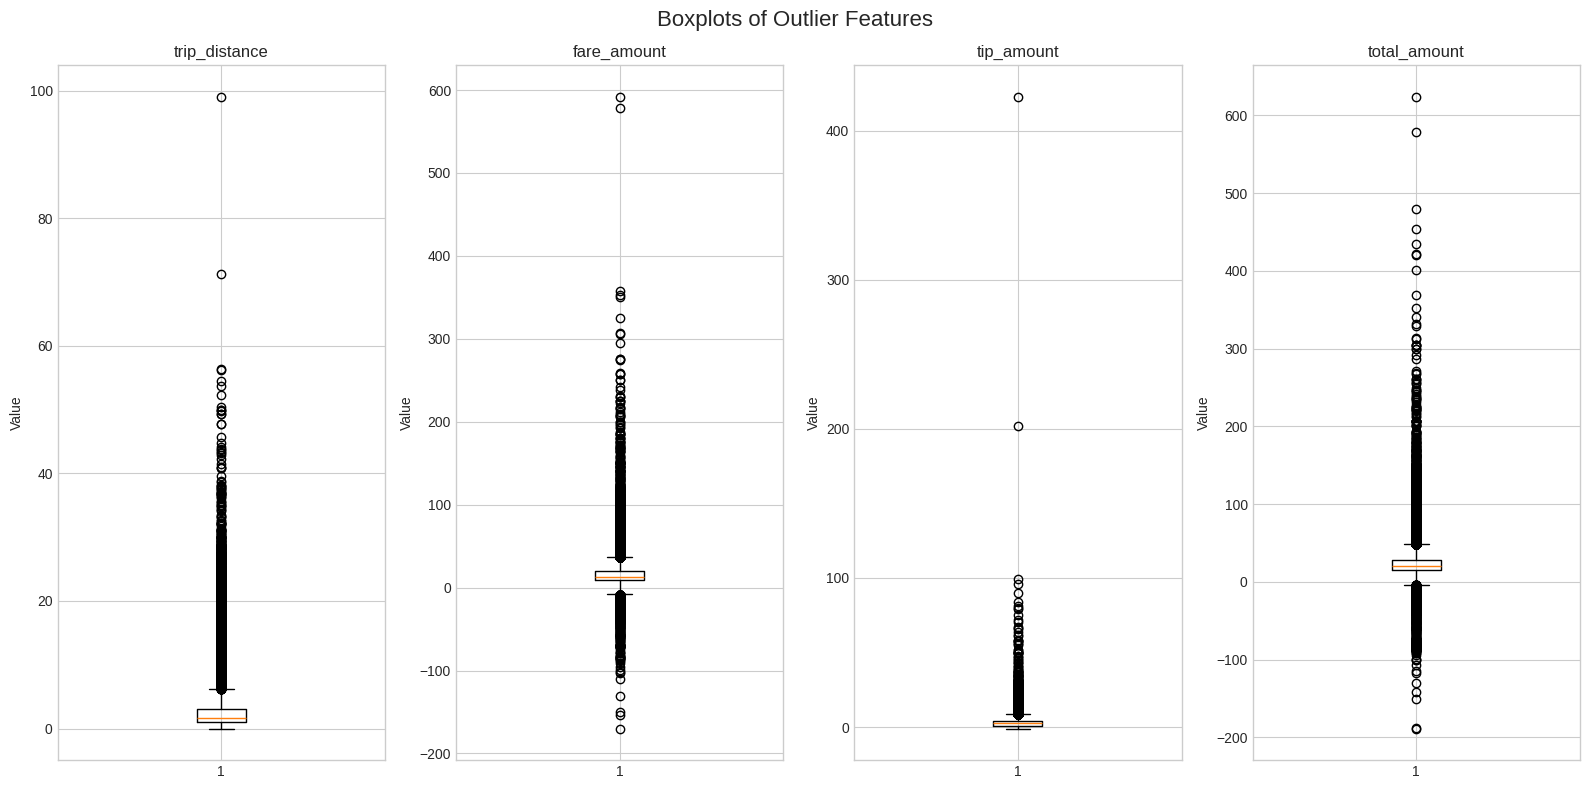

The boxes are squished because the outiers stretch y-axis
This itself tells us we have extreme values!


In [12]:
fig, axes = plt.subplots(1, 4, figsize=(16, 8))

for ax, col in zip(axes, ['trip_distance', 'fare_amount', 'tip_amount', 'total_amount']):
  ax.boxplot(df[col].dropna())
  ax.set_title(col)
  ax.set_ylabel('Value')

plt.suptitle('Boxplots of Outlier Features', fontsize=16)
plt.tight_layout()
plt.show()

print("The boxes are squished because the outiers stretch y-axis")
print("This itself tells us we have extreme values!")

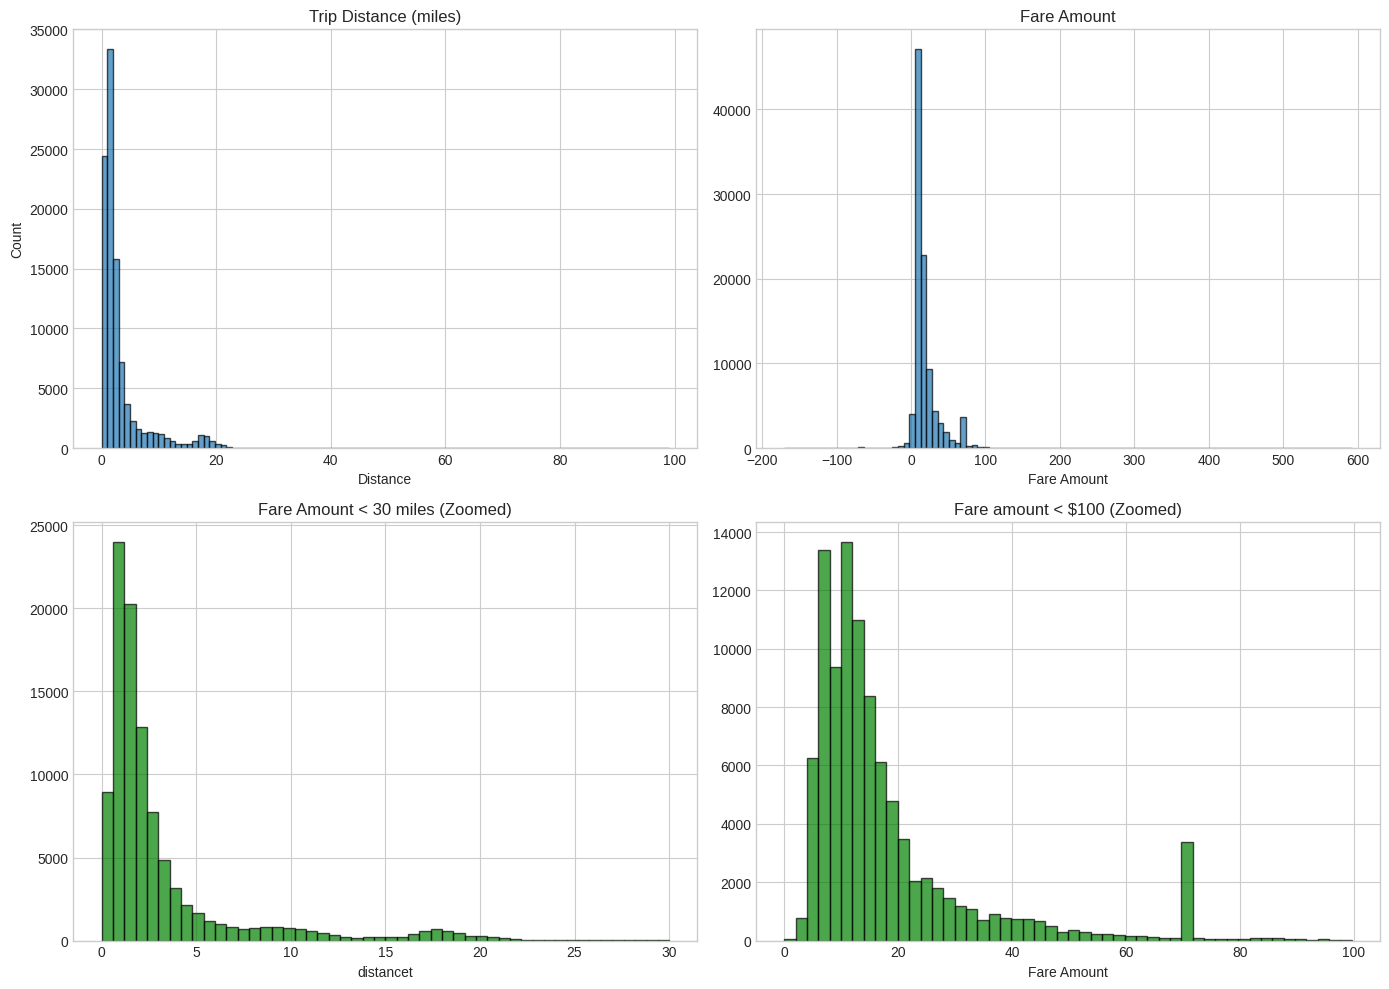

In [13]:
#Histograms
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Trip distance
axes[0, 0].hist(df['trip_distance'], bins=100, edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Trip Distance (miles)')
axes[0, 0].set_xlabel('Distance')
axes[0, 0].set_ylabel('Count')

# Fare amount
axes[0, 1].hist(df['fare_amount'], bins=100, edgecolor='black', alpha=0.7)
axes[0, 1].set_title('Fare Amount')
axes[0, 1].set_xlabel('Fare Amount')

#Zoomed in versions

axes[1, 0].hist(df[df['trip_distance'] < 30]['trip_distance'],
                bins=50, edgecolor='black', alpha=0.7, color='green')
axes[1, 0].set_title("Fare Amount < 30 miles (Zoomed)")
axes[1, 0].set_xlabel('distancet')

axes[1, 1].hist(df[(df['fare_amount'] > 0) & (df['fare_amount'] < 100)]['fare_amount'],
                bins=50, edgecolor='black', alpha=0.7, color='green')
axes[1, 1].set_title("Fare amount < $100 (Zoomed)")
axes[1, 1].set_xlabel('Fare Amount')

plt.tight_layout()
plt.show()

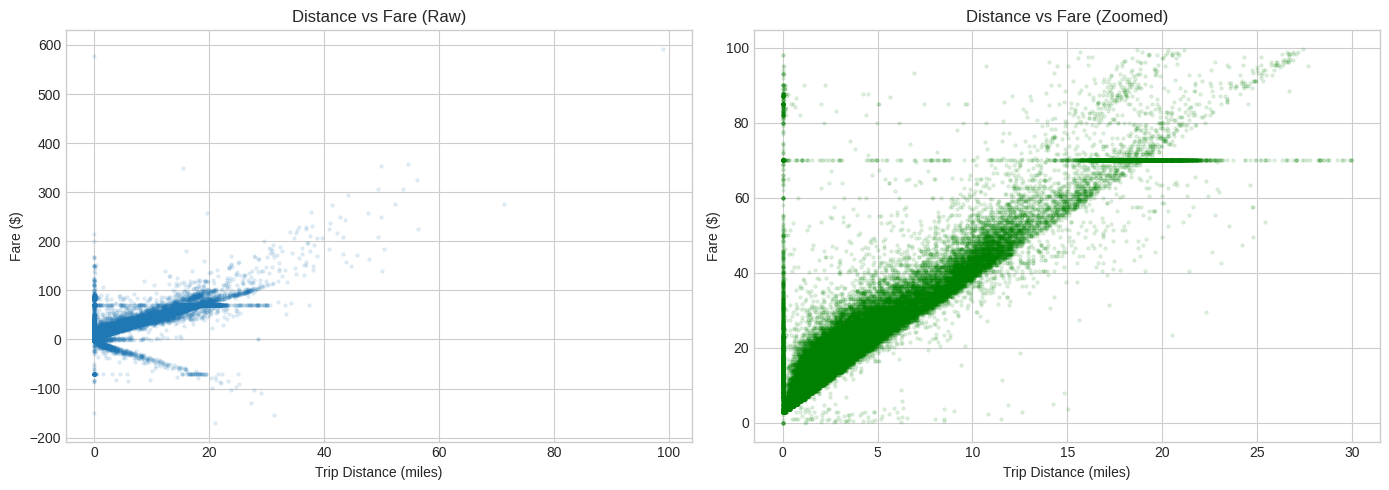

Notice:
- There's a clear linear relationship (more distance = more fare)
- But some points don't follow this pattern (outliers!)
- Some high fares with zero distance (minimum fare? airport fees?)


In [14]:
# Scatter plot: Distance vs Fare
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Raw
axes[0].scatter(df['trip_distance'], df['fare_amount'], alpha=0.1, s=5)
axes[0].set_xlabel('Trip Distance (miles)')
axes[0].set_ylabel('Fare ($)')
axes[0].set_title('Distance vs Fare (Raw)')

# Zoomed
mask = (df['trip_distance'] < 30) & (df['fare_amount'] > 0) & (df['fare_amount'] < 100)
axes[1].scatter(df.loc[mask, 'trip_distance'], df.loc[mask, 'fare_amount'], alpha=0.1, s=5, color='green')
axes[1].set_xlabel('Trip Distance (miles)')
axes[1].set_ylabel('Fare ($)')
axes[1].set_title('Distance vs Fare (Zoomed)')

plt.tight_layout()
plt.show()

print("Notice:")
print("- There's a clear linear relationship (more distance = more fare)")
print("- But some points don't follow this pattern (outliers!)")
print("- Some high fares with zero distance (minimum fare? airport fees?)")

Statistical Outllier detection

In [15]:
"""
Z-score (|Z| > 3 is often considered an outlier.)

"""
def detect_outliers_zscore(data, threshold=3):
  z_score = np.abs(stats.zscore(data, nan_policy='omit'))
  return z_score > threshold

#Apply to fare_amount
fare_outliers_zscore = detect_outliers_zscore(df['fare_amount'].dropna())

print(f"Z-score outlier detection (threshold=3):")
print(f"Total trips: {len(df['fare_amount'].dropna()):,}")
print(f"Total outliers: {fare_outliers_zscore.sum():,}")
print(f"Outliers: {fare_outliers_zscore.sum():,} ({fare_outliers_zscore.mean()*100:.2f}%)")


Z-score outlier detection (threshold=3):
Total trips: 100,000
Total outliers: 1,308
Outliers: 1,308 (1.31%)


In [16]:
#look at the outliers
fare_clean = df['fare_amount'].dropna()
outlier_fares = fare_clean[fare_outliers_zscore]

print(f"Outlier fares: ")
print(f"Min: ${outlier_fares.min():.2f}")
print(f"Max: ${outlier_fares.max():.2f}")
print(f"Mean: ${outlier_fares.mean():.2f}")

print(f"\n Sample Outlier fares:")
print(outlier_fares.head(20).values)

Outlier fares: 
Min: $-170.00
Max: $591.70
Mean: $75.15

 Sample Outlier fares:
[ 77.2  74.4  80.   86.   80.   94.  131.1 -65.3 100.  117.1  86.3  95.4
 -70.   85.   90.  118.  -72.3 -61.1  77.2  97.2]


IQR (Interquartile Range)

More robust to extreme outliers than Z-score.

Rule: Outlier if value < Q1 - 1.5×IQR or value > Q3 + 1.5×IQR

In [21]:
def detect_outliers_iqr(data, multiplier=1.5):
  Q1 = data.quantile(0.25)
  Q3 = data.quantile(0.75)
  IQR = Q3 - Q1

  lower_bound = Q1 - multiplier * IQR
  upper_bound = Q3 + multiplier * IQR

  return (data < lower_bound) | (data > upper_bound), lower_bound, upper_bound

#Apply to face_amount
fare_outliers_iqr, lower, upper = detect_outliers_iqr(df['fare_amount'].dropna())

print(f"IQR outlier detection (multiplier=1.5)")
print(f"Lower bound: ${lower:.2f}")
print(f"Upper bound: ${upper:.2f}")
print(f"Outliers: {fare_outliers_iqr.sum():,} ({fare_outliers_iqr.mean()*100:.2f}%)")

IQR outlier detection (multiplier=1.5)
Lower bound: $-8.20
Upper bound: $36.60
Outliers: 11,271 (11.27%)


In [22]:
#Compare methods
print("Comparison of methods:")
print('='*50)

for col in ['fare_amount', 'trip_distance', 'tip_amount']:
  data = df[col].dropna()

  zscore_outliers = detect_outliers_zscore(data)
  iqr_outliers, _, _ = detect_outliers_iqr(data)

  print(f"{col}:")
  print(f"Z-score: {zscore_outliers.sum():,} outliers ({zscore_outliers.mean()*100:.2f}%)")
  print(f"IQR: {iqr_outliers.sum():,} outliers ({iqr_outliers.mean()*100:.2f}")

Comparison of methods:
fare_amount:
Z-score: 1,308 outliers (1.31%)
IQR: 11,271 outliers (11.27
trip_distance:
Z-score: 4,126 outliers (4.13%)
IQR: 12,695 outliers (12.70
tip_amount:
Z-score: 2,425 outliers (2.43%)
IQR: 7,186 outliers (7.19


Why IQR finds more outliers?
IQR is based on percentiles (25th and 75th), which are more sensitive to the "bulk" of the data.

Z-Score is based on mean and std, which are themselves affected by outliers (so extreme outliers "hide" other outliers).

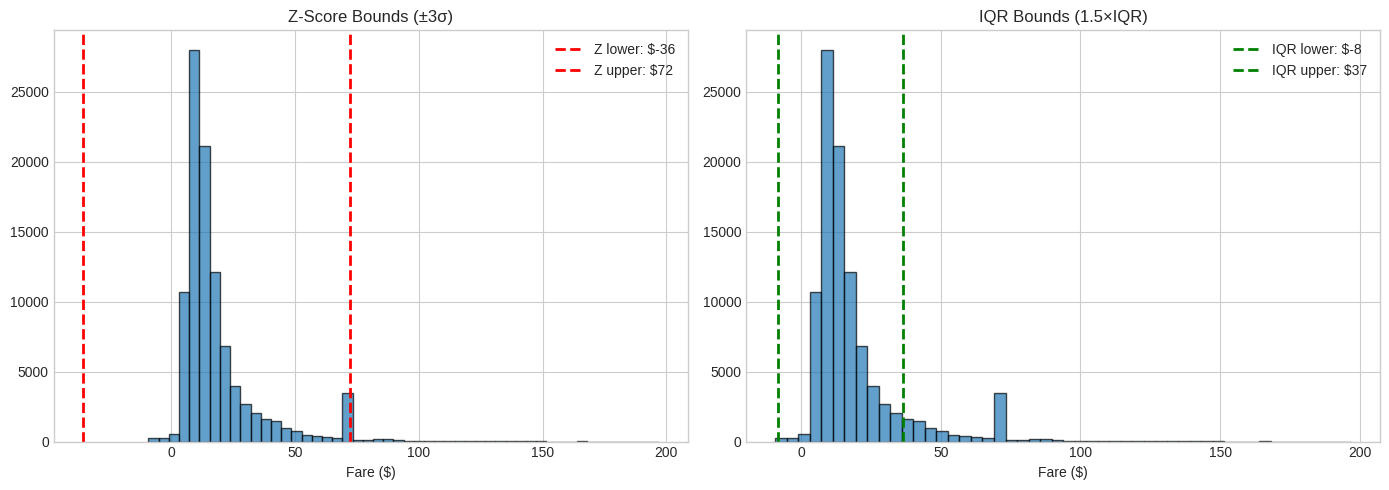

Z-Score allows fares up to $72
IQR allows fares up to $37

IQR is more conservative (stricter bounds)


In [24]:
#visualize the bounds
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

col = 'fare_amount'
data = df[col].dropna()
data_reasonable = data[(data > -10) & (data < 200)]  # Zoom in

# Z-Score bounds
mean, std = data.mean(), data.std()
z_lower, z_upper = mean - 3*std, mean + 3*std

axes[0].hist(data_reasonable, bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(z_lower, color='red', linestyle='--', linewidth=2, label=f'Z lower: ${z_lower:.0f}')
axes[0].axvline(z_upper, color='red', linestyle='--', linewidth=2, label=f'Z upper: ${z_upper:.0f}')
axes[0].set_title('Z-Score Bounds (±3σ)')
axes[0].set_xlabel('Fare ($)')
axes[0].legend()

# IQR bounds
_, iqr_lower, iqr_upper = detect_outliers_iqr(data)

axes[1].hist(data_reasonable, bins=50, edgecolor='black', alpha=0.7)
axes[1].axvline(iqr_lower, color='green', linestyle='--', linewidth=2, label=f'IQR lower: ${iqr_lower:.0f}')
axes[1].axvline(iqr_upper, color='green', linestyle='--', linewidth=2, label=f'IQR upper: ${iqr_upper:.0f}')
axes[1].set_title('IQR Bounds (1.5×IQR)')
axes[1].set_xlabel('Fare ($)')
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"Z-Score allows fares up to ${z_upper:.0f}")
print(f"IQR allows fares up to ${iqr_upper:.0f}")
print(f"\nIQR is more conservative (stricter bounds)")

ML-Based Outlier detection

In [27]:
"""
Isolation Forest

"""
from sklearn.ensemble import IsolationForest

features = ['trip_distance', 'fare_amount', 'tip_amount', 'total_amount', 'passenger_count']
df_model = df[features].dropna()

print(f"Sampples for modelling: {len(df_model):,}")

Sampples for modelling: 95,273


In [30]:
#Fit Isolation forest
iso_forest = IsolationForest(contamination=0.05, random_state=42, n_jobs=-1)

#predict: 1 = normal, -1 = outlier
prediction = iso_forest.fit_predict(df_model)

#convert to boolean
iso_outliers = prediction == -1

print(f"Outliers: {iso_outliers.sum():,} ({iso_outliers.mean()*100:.2f}%)")

Outliers: 4,763 (5.00%)


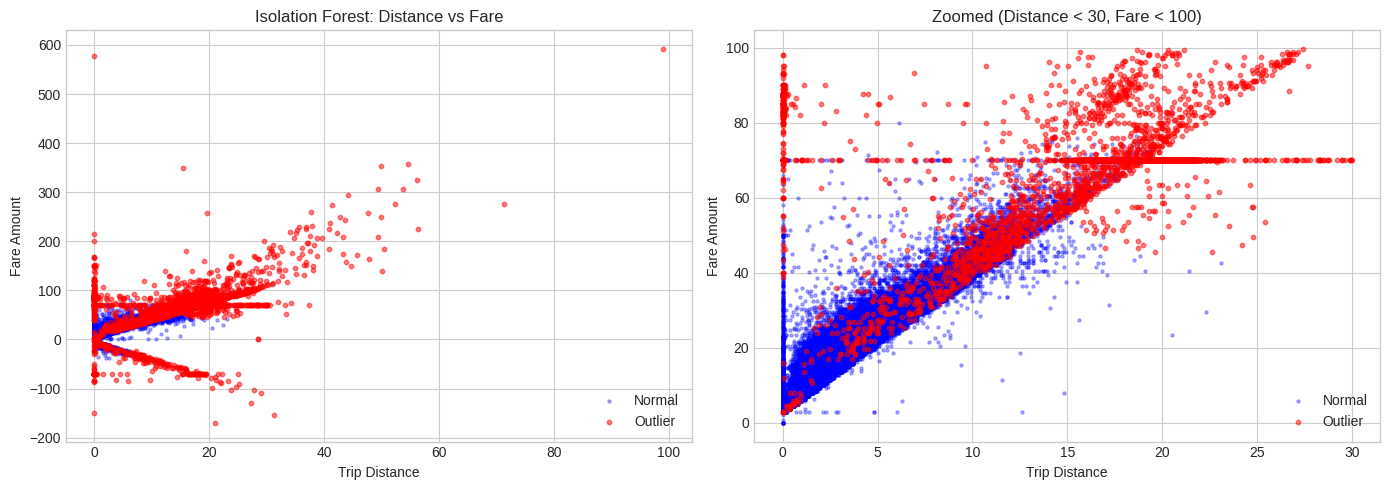

In [35]:
# Visualize Isolation Forest results
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Normal points
normal = df_model[~iso_outliers]
outliers = df_model[iso_outliers]

axes[0].scatter(normal['trip_distance'], normal['fare_amount'],
                alpha=0.3, s=5, label='Normal', color='blue')
axes[0].scatter(outliers['trip_distance'], outliers['fare_amount'],
                alpha=0.5, s=10, label='Outlier', color='red')
axes[0].set_xlabel('Trip Distance')
axes[0].set_ylabel('Fare Amount')
axes[0].set_title('Isolation Forest: Distance vs Fare')
axes[0].legend()

# Zoomed version
mask_zoom = (df_model['trip_distance'] < 30) & (df_model['fare_amount'] < 100) & (df_model['fare_amount'] > 0)
normal_zoom = df_model[~iso_outliers & mask_zoom]
outliers_zoom = df_model[iso_outliers & mask_zoom]

axes[1].scatter(normal_zoom['trip_distance'], normal_zoom['fare_amount'],
                alpha=0.3, s=5, label='Normal', color='blue')
axes[1].scatter(outliers_zoom['trip_distance'], outliers_zoom['fare_amount'],
                alpha=0.5, s=10, label='Outlier', color='red')
axes[1].set_xlabel('Trip Distance')
axes[1].set_ylabel('Fare Amount')
axes[1].set_title('Zoomed (Distance < 30, Fare < 100)')
axes[1].legend()

plt.tight_layout()
plt.show()

Method 4: Local Outlier Factor (LOF)

Compares the local density of a point to its neighbors. Points in sparse regions are outliers.

In [36]:
from sklearn.neighbors import LocalOutlierFactor

#use a smaller sample for LOF (its slower)
df_lof_sample = df_model.sample(n=20000, random_state=42)

#fit LOF
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)
lof_predictions = lof.fit_predict(df_lof_sample)

lof_outliers = lof_predictions == -1

print(f"Outliers: {lof_outliers.sum():,} ({lof_outliers.mean()*100:.2f}%)")

Outliers: 1,000 (5.00%)


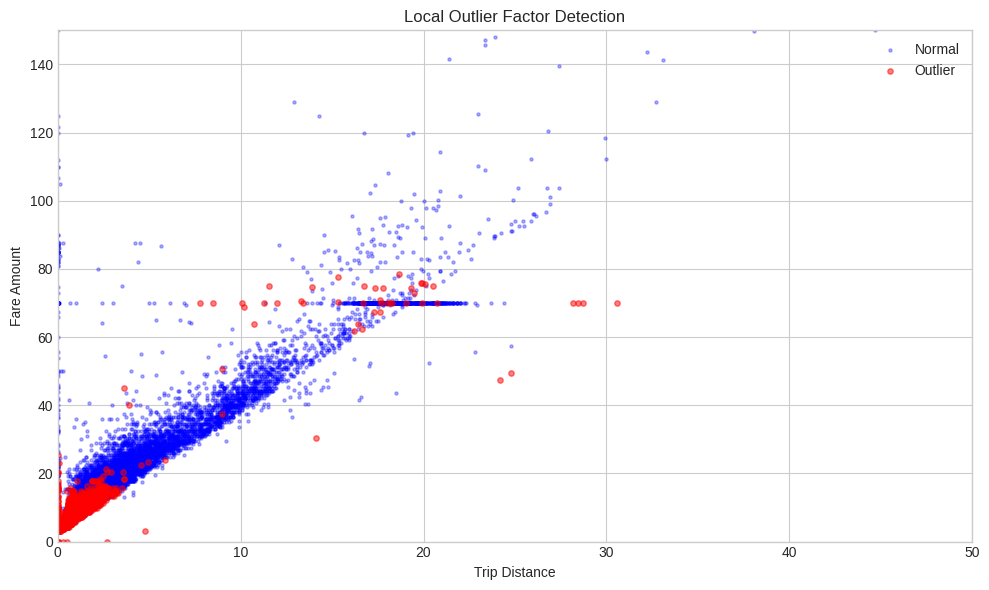

In [44]:
#Visualize the LOF results
fig, ax = plt.subplots(figsize=(10, 6))

normal_lof = df_lof_sample[~lof_outliers]
outliers_lof = df_lof_sample[lof_outliers]

ax.scatter(normal_lof['trip_distance'], normal_lof['fare_amount'],
           alpha=0.3, s=5, label='Normal', color='blue')
ax.scatter(outliers_lof['trip_distance'], outliers_lof['fare_amount'],
           alpha=0.5, s=15, label='Outlier', color='red')
ax.set_xlabel('Trip Distance')
ax.set_ylabel("Fare Amount")
ax.set_title("Local Outlier Factor Detection")
ax.legend()
ax.set_xlim(0, 50)
ax.set_ylim(0, 150)

plt.tight_layout()
plt.show()

Domain-Specific Outliers Results

In [46]:
def detect_taxi_outliers(df):
  outliers = pd.DataFrame(index=df.index)

  #1. Negative fare
  outliers['negative_fare'] = df['fare_amount'] < 0

  #2. Zero Passengers
  outliers['zero_passengers'] = df['passenger_count'] < 0

  #3. Extremely long trips(NYC is ~13 miles across)
  outliers['extreme_distance'] = df['trip_distance'] > 100

  #4. Zero distance but high fare
  outliers['zero_distance_high_fare'] = (df['trip_distance'] == 0) & (df['fare_amount'] > 50)

  #5. Very high tip percentage(>100% of the fare)
  expected_fare = 3 + 2.5 * df['trip_distance']
  outliers['extreme_trip'] = (df['fare_amount'] > expected_fare * 3) | (df['fare_amount'] < expected_fare * 0.3)

  #combined
  outliers['any_outlier'] = outliers.any(axis=1)

  return outliers

#Apply
domain_outliers = detect_taxi_outliers(df)

print("Domain-based Outlier Detection:")
print("="*50)

for col in domain_outliers.columns:
  count = domain_outliers[col].sum()
  percentage = count / len(domain_outliers)
  print(f"{col}: {count:,} ({percentage*100:.2f}%)")

Domain-based Outlier Detection:
negative_fare: 1,306 (1.31%)
zero_passengers: 0 (0.00%)
extreme_distance: 0 (0.00%)
zero_distance_high_fare: 293 (0.29%)
extreme_trip: 3,795 (3.79%)
any_outlier: 3,795 (3.79%)


In [47]:
# Look at some domain outliers
print("\nSample trips with negative fares:")
print(df[domain_outliers['negative_fare']][['trip_distance', 'fare_amount', 'tip_amount', 'total_amount']].head(10))


Sample trips with negative fares:
     trip_distance  fare_amount  tip_amount  total_amount
143           0.80        -7.20         0.0        -13.70
166           1.92        -0.12         0.0          3.88
272           0.71        -7.20         0.0        -13.70
277           1.86       -12.80         0.0        -17.80
450           0.85       -10.70         0.0        -14.70
640           0.55        -5.10         0.0         -9.10
852           1.29       -14.20         0.0        -19.20
854           4.73       -20.50         0.0        -31.25
935           0.00       -11.00         0.0        -12.00
978          16.17       -65.30         0.0        -69.55


In [48]:
print("\nSample trips with zero passengers:")
print(df[domain_outliers['zero_passengers']][['trip_distance', 'fare_amount', 'passenger_count']].head(10))


Sample trips with zero passengers:
Empty DataFrame
Columns: [trip_distance, fare_amount, passenger_count]
Index: []


In [49]:
print("\nSample trips with extreme distance (>100 miles):")
print(df[domain_outliers['extreme_distance']][['trip_distance', 'fare_amount', 'total_amount']].head(10))


Sample trips with extreme distance (>100 miles):
Empty DataFrame
Columns: [trip_distance, fare_amount, total_amount]
Index: []


## What to Do with Outliers?

Three main strategies:

| Strategy | When to Use | Example |
|----------|-------------|--------|
| **Remove** | Clearly erroneous data | Negative fares, 0 passengers |
| **Cap (Winsorize)** | Extreme but plausible | Very high fares |
| **Keep** | Genuine extreme values | Long airport trips |

In [50]:
#Stategy 1: Remove Clear Errors
df_clean = df.copy()

#remove negative fares and zero passengers
before = len(df_clean)
df_clean = df_clean[
    (df_clean['fare_amount'] >= 0) &
    (df_clean['passenger_count'] > 0) &
    (df_clean['trip_distance'] >= 0)
]

after = len(df_clean)

print(f"Removed {before - after:,} clearly erroneous trips ({(before - after)/before*100:.2f}%)")
print(f"Remaining: {after:,} trips")

Removed 7,055 clearly erroneous trips (7.05%)
Remaining: 92,945 trips


In [52]:
# Strategy 2: Cap extreme values (Winsorizing)
def winsorize(data, lower_pct=0.01, upper_pct=0.99):
  """
  Cap values at specified percentages

  """
  lower = data.quantile(lower_pct)
  upper = data.quantile(upper_pct)
  return data.clip(lower=lower, upper=upper)

#Apply to fare
fare_original = df_clean['fare_amount'].copy()
fare_capped = winsorize(df_clean['fare_amount'], lower_pct=0.01, upper_pct=0.99)

print(f"Fare capping (1st to 99th percentile)")
print(f"Original max: ${fare_original.max():.2f}")
print(f"Capped max: ${fare_capped.max():.2f}")
print(f"Original min: ${fare_original.min():.2f}")
print(f"Capped min: ${fare_capped.min():.2f}")

Fare capping (1st to 99th percentile)
Original max: $591.70
Capped max: $75.80
Original min: $0.00
Capped min: $4.40


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.12/dist-packages/matplotlib/pyplot.py'>

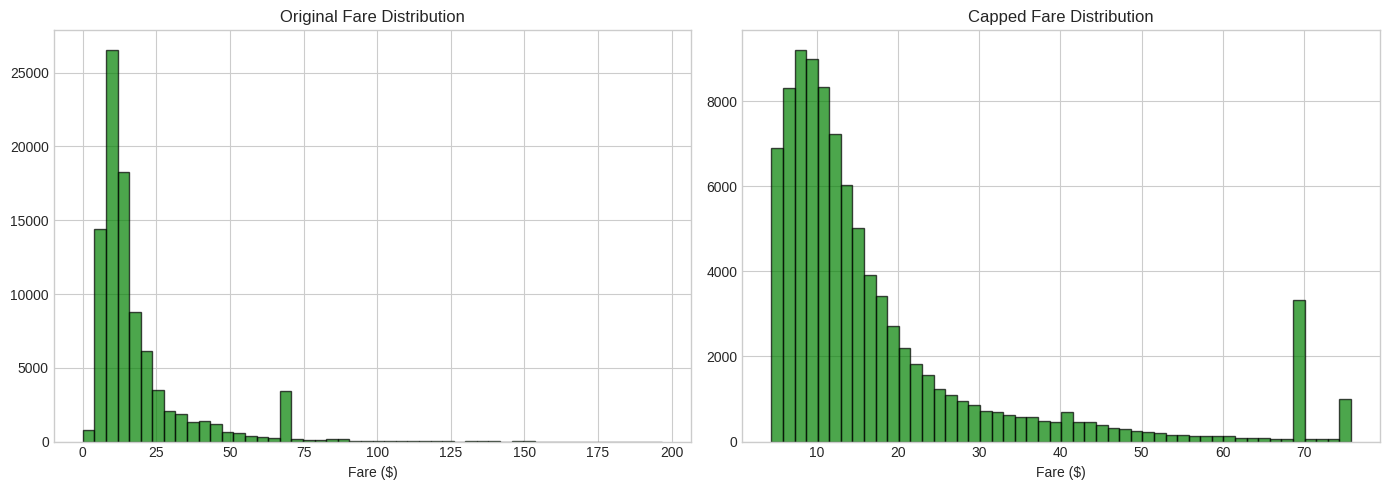

In [53]:
#Compare distributions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(fare_original[fare_original < 200], bins=50, edgecolor='black', alpha=0.7, color='g')
axes[0].set_title("Original Fare Distribution")
axes[0].set_xlabel("Fare ($)")

axes[1].hist(fare_capped, bins=50, edgecolor='black', alpha=0.7, color='g')
axes[1].set_title("Capped Fare Distribution")
axes[1].set_xlabel("Fare ($)")

plt.tight_layout()
plt

Impact of outlier handling on statistics

In [56]:
#Compare statistics before and after outlier handling
print("Impact of outlier handling on Fare Statistics:")
print("="*60)

print(f"\n{'statistics':<15} {"Raw":<15} {'cleaned':<15} {"capped":<15}")
print("-"*60)

raw = df['fare_amount'].dropna()
cleaned = df_clean['fare_amount']
capped = fare_capped

for stat_name, stat_func in [('Mean', np.mean), ('Median', np.median),
                             ('Std', np.std), ('Max', np.max), ('Min', np.min)]:
  raw_val = stat_func(raw)
  clean_val = stat_func(cleaned)
  cap_val = stat_func(capped)
  print(f"{stat_name:<15} ${raw_val:<14.2f} ${clean_val:<14.2f} ${cap_val:<14.2f}")


Impact of outlier handling on Fare Statistics:

statistics      Raw             cleaned         capped         
------------------------------------------------------------
Mean            $18.09          $18.53          $18.25         
Median          $12.80          $12.80          $12.80         
Std             $18.01          $17.68          $15.88         
Max             $591.70         $591.70         $75.80         
Min             $-170.00        $0.00           $4.40          


In [57]:
# Impact on correlation
print("\nCorrelation between Distance and Fare:")
print("="*50)

# Raw
raw_corr = df[['trip_distance', 'fare_amount']].dropna().corr().iloc[0, 1]

# Cleaned
clean_corr = df_clean[['trip_distance', 'fare_amount']].corr().iloc[0, 1]

# Capped
df_capped = df_clean.copy()
df_capped['fare_amount'] = fare_capped
df_capped['trip_distance'] = winsorize(df_capped['trip_distance'], 0.01, 0.99)
capped_corr = df_capped[['trip_distance', 'fare_amount']].corr().iloc[0, 1]

print(f"  Raw data:     {raw_corr:.4f}")
print(f"  Cleaned data: {clean_corr:.4f}")
print(f"  Capped data:  {capped_corr:.4f}")

print(f"\n→ Outliers were weakening the distance-fare correlation!")


Correlation between Distance and Fare:
  Raw data:     0.8518
  Cleaned data: 0.9076
  Capped data:  0.9296

→ Outliers were weakening the distance-fare correlation!



## Key Takeaways

### Methods Comparison:

| Method | Pros | Cons | Best For |
|--------|------|------|----------|
| **Z-Score** | Simple, interpretable | Affected by outliers | Nearly normal data |
| **IQR** | Robust to extremes | More aggressive | Skewed data |
| **Isolation Forest** | Multivariate, no assumptions | Black box, needs tuning | Complex patterns |
| **LOF** | Finds local outliers | Slow, needs tuning | Clustered data |
| **Domain Rules** | Most accurate | Requires expertise | Known constraints |

### Handling Strategies:

| Strategy | When to Use |
|----------|------------|
| **Remove** | Clear errors (negative prices, impossible values) |
| **Cap** | Extreme but plausible (very high prices) |
| **Keep** | Genuine extremes important for analysis |
| **Flag** | When unsure, add indicator column |

### NYC Taxi Insights:

- ~1-5% of trips have some kind of data quality issue
- Negative fares are likely refunds or errors
- Zero passengers might be test trips or data errors
- Extreme distances could be airport trips or errors
